# KMeans for player clustering

In this notebook, we will train an unsupervised machine learning algorithm called KMeans.

KMeans is capable of discovering patterns in data and creating groups of data points.

In this notebook, we will use a dataset I scraped from FBREF on my own.

This dataset contains players stats of the Argentinian league. We want to cluster __midfielders__ that share similar characteristics. For example, more defensive, more offensive, playmaker, box-to-box, etc.

First we import the necessary packages.

In [88]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

Let's start by reading the dataset using pandas.


In [89]:
players_df = pd.read_csv('FBRef_2024_CopaDeLaLiga.csv')

## Data preprocessing and cleanup

First, we examine what data we have at our disposal.
We use .head() function to see the data itself.
We will use .info() to see all columns, column types and any NaN values

In [90]:
players_df.head()

,Unnamed: 0,Rk,Player,Nation,Pos,Squad,Age,Born,Matches Played,Starts,...,Interceptions,Passes Blocked,Shots Blocked,Tackles,Tackles Att 3rd,Tackles Def 3rd,Tackles Mid 3rd,Tackles Won,Tackles+Interceptions,Total Blocks
0,0,1,Matías Abaldo,uy URU,"MF,FW",Gimnasia ELP,20-025,2004,7,5,...,2,4,0,4,1,3,0,2,6,4
1,1,2,Luciano Abecasis,ar ARG,"MF,DF",Independiente Rivadavia,33-329,1990,12,10,...,2,10,1,19,0,4,15,11,21,11
2,2,3,Ramón Ábila,ar ARG,FW,Barracas Central,34-197,1989,9,0,...,0,0,0,0,0,0,0,0,0,0
3,3,4,Jonás Acevedo,ar ARG,"MF,FW",Instituto,27-082,1997,9,6,...,3,6,1,13,4,5,4,7,16,7
4,4,5,Guillermo Acosta,ar ARG,MF,Tucumán,35-180,1988,10,10,...,12,3,1,17,0,5,12,9,29,4


In [91]:
players_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 797 entries, 0 to 796
Data columns (total 88 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   Unnamed: 0                    797 non-null    int64 
 1   Rk                            797 non-null    object
 2   Player                        797 non-null    object
 3   Nation                        788 non-null    object
 4   Pos                           796 non-null    object
 5   Squad                         797 non-null    object
 6   Age                           788 non-null    object
 7   Born                          788 non-null    object
 8   Matches Played                797 non-null    object
 9   Starts                        797 non-null    object
 10  Min                           797 non-null    object
 11  90s                           797 non-null    object
 12  Gls                           797 non-null    object
 13  Ast                 

First, we want to reduce our sample to players whose main position is midfielder ("MF"). There are midfielders that can also play as DF or FW.

In [92]:
# Filter by position
players_df = players_df[
    (players_df["Pos"] == "MF") |
    (players_df["Pos"] == "MF,FW") |
    (players_df["Pos"] == "MF,DF")
]


Which are the metrics that are going to help our algorithm cluster the different type of midfielders?
We exclude metrics that are not significant and will hinder our algorithm.
We exclude 90' metrics since we are going to calculate them later.
We also excluded accuracy metrics, for example, the number of correct passes will not help us deduce the characteristics and behaviour of midfielders.

In [93]:
metrics = ['Player', "Min", 'Gls', 'Ast', 'xG', 'xAG',
       'Progressive Carries', 'Progressive Passes', 'Crosses into Penalty Area', 'Key Passes',
       'Long Passes Attempted', 'Medium Passes Attempted',
       'Passes into Final Third', 'Passes into Penalty Area',
       'Progressive Passing Distance', 'Short Passes Attempted', 'Total Passing Distance', 'xA', 'Through Balls', 'Clearances',
       'Interceptions', 'Tackles', 'Total Blocks']

players_df = players_df[metrics]
players_df.columns

Index(['Player', 'Min', 'Gls', 'Ast', 'xG', 'xAG', 'Progressive Carries',
       'Progressive Passes', 'Crosses into Penalty Area', 'Key Passes',
       'Long Passes Attempted', 'Medium Passes Attempted',
       'Passes into Final Third', 'Passes into Penalty Area',
       'Progressive Passing Distance', 'Short Passes Attempted',
       'Total Passing Distance', 'xA', 'Through Balls', 'Clearances',
       'Interceptions', 'Tackles', 'Total Blocks'],
      dtype='object')

Convert all columns to numeric, excluding the "Player" column whcih is the first index

In [94]:
# Convert all columns except the first one to numeric values explicitly
for col in players_df.columns[1:]:
    players_df[col] = pd.to_numeric(players_df[col], errors='coerce')


# Check the data types
players_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 277 entries, 0 to 796
Data columns (total 23 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Player                        277 non-null    object 
 1   Min                           277 non-null    int64  
 2   Gls                           277 non-null    int64  
 3   Ast                           277 non-null    int64  
 4   xG                            256 non-null    float64
 5   xAG                           256 non-null    float64
 6   Progressive Carries           256 non-null    float64
 7   Progressive Passes            256 non-null    float64
 8   Crosses into Penalty Area     256 non-null    float64
 9   Key Passes                    256 non-null    float64
 10  Long Passes Attempted         256 non-null    float64
 11  Medium Passes Attempted       256 non-null    float64
 12  Passes into Final Third       256 non-null    float64
 13  Passes int

Players that did not play sufficient amount of minutes will have data that may not be accurate to the player. We exclude players with less than 600 minutes played that season.

In [95]:
# Filter the DataFrame for rows where 'Min' > 500
players_df = players_df[players_df['Min'] > 500]
players_df.reset_index(inplace=True, drop=True)

players_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112 entries, 0 to 111
Data columns (total 23 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Player                        112 non-null    object 
 1   Min                           112 non-null    int64  
 2   Gls                           112 non-null    int64  
 3   Ast                           112 non-null    int64  
 4   xG                            104 non-null    float64
 5   xAG                           104 non-null    float64
 6   Progressive Carries           104 non-null    float64
 7   Progressive Passes            104 non-null    float64
 8   Crosses into Penalty Area     104 non-null    float64
 9   Key Passes                    104 non-null    float64
 10  Long Passes Attempted         104 non-null    float64
 11  Medium Passes Attempted       104 non-null    float64
 12  Passes into Final Third       104 non-null    float64
 13  Passe

There are columns that do not contain any data, we can see that the Gls and Ast columns have less Non-null values, we want to delete rows most columns are NaN

In [96]:
columns_to_check = ["Short Passes Attempted", "Medium Passes Attempted"]

# Drop rows where these columns have NaN values
players_df = players_df.dropna(subset=columns_to_check)
players_df.reset_index(inplace=True, drop=True)

players_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104 entries, 0 to 103
Data columns (total 23 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Player                        104 non-null    object 
 1   Min                           104 non-null    int64  
 2   Gls                           104 non-null    int64  
 3   Ast                           104 non-null    int64  
 4   xG                            104 non-null    float64
 5   xAG                           104 non-null    float64
 6   Progressive Carries           104 non-null    float64
 7   Progressive Passes            104 non-null    float64
 8   Crosses into Penalty Area     104 non-null    float64
 9   Key Passes                    104 non-null    float64
 10  Long Passes Attempted         104 non-null    float64
 11  Medium Passes Attempted       104 non-null    float64
 12  Passes into Final Third       104 non-null    float64
 13  Passe

We want to convert all the metrics to per 90' scale, first we copy the dataframe into another variable

In [97]:
players_90 = players_df.copy(deep=True)

Create a new column for the matches played, which is the player's total minutes divided by 90

In [98]:
players_90["Min_per_90"] = players_90["Min"] / 90

players_90[["Player", "Min", "Min_per_90"]].head()

,Player,Min,Min_per_90
0,Luciano Abecasis,860,9.555556
1,Jonás Acevedo,555,6.166667
2,Guillermo Acosta,782,8.688889
3,Gabriel Alanís,546,6.066667
4,William Alarcón,1101,12.233333


In [99]:
# Perform the division for columns starting from the third column
players_90.iloc[:, 2:] = players_90.iloc[:, 2:].div(players_90["Min_per_90"], axis=0)

players_90.head()

/var/folders/6v/mydq28cs5jsf5r12rn8vl4vr0000gn/T/ipykernel_1377/4256740702.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0      0.104651
1      0.000000
2      0.115090
3      0.164835
4      0.163488
         ...   
99     0.113493
100    0.000000
101    0.000000
102    0.151388
103    0.097087
Name: Gls, Length: 104, dtype: float64' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  players_90.iloc[:, 2:] = players_90.iloc[:, 2:].div(players_90["Min_per_90"], axis=0)
/var/folders/6v/mydq28cs5jsf5r12rn8vl4vr0000gn/T/ipykernel_1377/4256740702.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0      0.104651
1      0.324324
2      0.000000
3      0.164835
4      0.245232
         ...   
99     0.113493
100    0.000000
101    0.000000
102    0.227082
103    0.194175
Name: Ast, Length: 104, dtype: floa

,Player,Min,Gls,Ast,xG,xAG,Progressive Carries,Progressive Passes,Crosses into Penalty Area,Key Passes,...,Progressive Passing Distance,Short Passes Attempted,Total Passing Distance,xA,Through Balls,Clearances,Interceptions,Tackles,Total Blocks,Min_per_90
0,Luciano Abecasis,860,0.104651,0.104651,0.010465,0.136047,1.255814,4.500000,0.837209,1.674419,...,175.290698,16.953488,543.244186,0.167442,0.000000,1.046512,0.209302,1.988372,1.151163,1.0
1,Jonás Acevedo,555,0.000000,0.324324,0.145946,0.324324,2.756757,4.378378,0.324324,2.270270,...,144.486486,15.729730,446.918919,0.340541,0.162162,0.162162,0.486486,2.108108,1.135135,1.0
2,Guillermo Acosta,782,0.115090,0.000000,0.046036,0.069054,1.381074,6.329923,0.115090,1.035806,...,237.774936,15.421995,643.120205,0.069054,0.115090,1.726343,1.381074,1.956522,0.460358,1.0
3,Gabriel Alanís,546,0.164835,0.164835,0.197802,0.032967,2.802198,1.648352,0.164835,0.659341,...,46.978022,10.219780,244.945055,0.016484,0.164835,0.824176,0.164835,2.307692,0.824176,1.0
4,William Alarcón,1101,0.163488,0.245232,0.040872,0.147139,1.389646,8.174387,0.163488,0.899183,...,255.367847,19.700272,692.942779,0.138965,0.326975,1.144414,0.735695,1.226158,0.245232,1.0


Now we drop the minutes columns

In [100]:
players_90.drop(columns=["Min_per_90", "Min"], inplace=True)

## Feature Engineering

We want to reduce the scale of each feature by normalizing the data

In [101]:
minmax_scaler = MinMaxScaler()

# Exclude the player column
norm_X = players_df.iloc[:, 1:]

# We want to replace NaN values with 0
norm_X.fillna(0, inplace=True)

# Save the columns, so we create the dataframe again
cols = norm_X.columns

# Perform the normalization
norm_X = minmax_scaler.fit_transform(norm_X.to_numpy())

For KMeans algorithm, we want to reduce the numbers of components for an easier cluster using Principal Component Analysis (PCA)

In [102]:
pca = PCA(n_components=2)

reduced = pca.fit_transform(norm_X)
reduced = pd.DataFrame(reduced)

reduced.head()


,0,1
0,0.154462,-0.301112
1,-0.461287,-0.580656
2,-0.131928,0.158413
3,-0.997610,-0.438342
4,0.884441,0.070743


What would be a good number of clusters?
There are different types of midfielders, for example we can have more offensive midfielders, playmakers, box to box, defensive midfielders, etc.

The elbow method will help find us find the number of clusters that would be optmal for our data.
WCSS variable will contain the wcss for each cluster, which is the distance between points within each cluster, the lower the more compact clusters are.

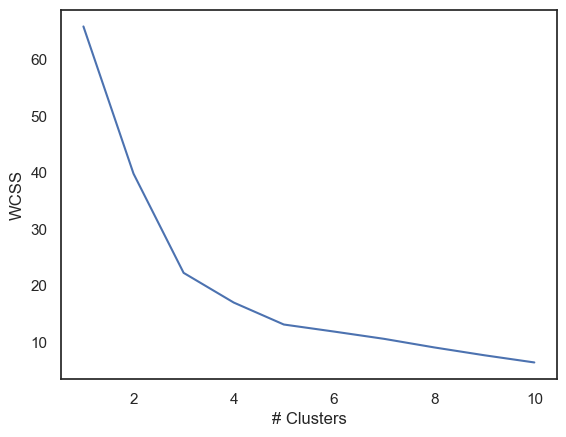

In [103]:
wcss = []

for i in range(1,11):
        kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state=42)
        kmeans.fit(reduced)
        wcss.append(kmeans.inertia_)

plt.plot(range(1,11), wcss)
plt.xlabel("# Clusters")
plt.ylabel("WCSS")
plt.show()


Now that we found an optimal number of clusters, we train the model.

In [104]:
kmeans = KMeans(n_clusters=4)
kmeans = kmeans.fit(reduced)

labels = kmeans.predict(reduced)
clusters = kmeans.labels_.tolist()

We need to combine player names with 

In [105]:
players = players_df["Player"]

reduced['cluster'] = clusters
reduced['Player'] = players
reduced.columns = ['x', 'y', 'cluster', 'Player']
reduced

,x,y,cluster,Player
0,0.154462,-0.301112,2,Luciano Abecasis
1,-0.461287,-0.580656,3,Jonás Acevedo
2,-0.131928,0.158413,3,Guillermo Acosta
3,-0.997610,-0.438342,3,Gabriel Alanís
4,0.884441,0.070743,2,William Alarcón
...,...,...,...,...
99,-0.442879,-0.290450,3,Renzo Tesuri
100,-0.668669,0.098804,3,Rodrigo Villagra
101,-0.544911,0.369573,3,Carlos Villalba
102,1.673887,-1.252324,1,Kevin Zenon


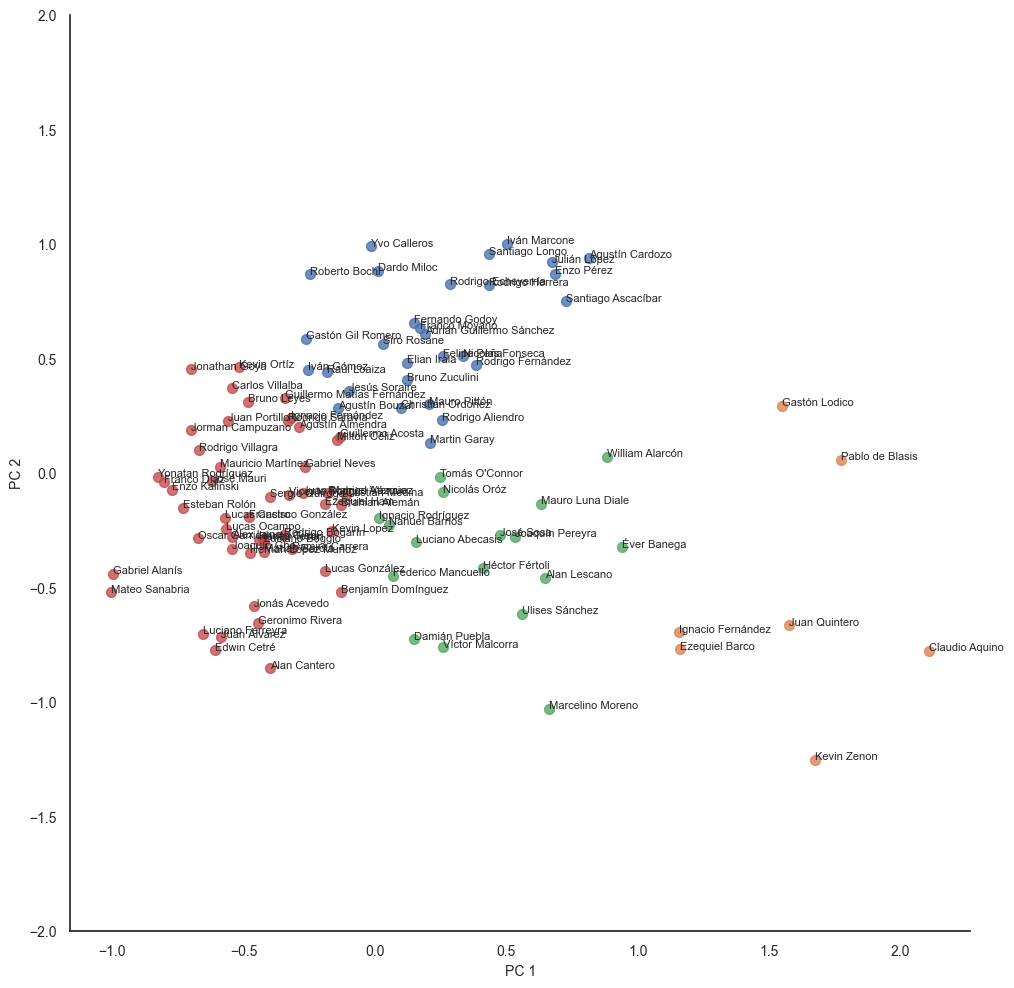

In [106]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="white")

# Create the plot
ax = sns.lmplot(x="x", y="y", hue='cluster', data=reduced, legend=False,
                fit_reg=False, height=10, scatter_kws={"s": 50})

# Add text annotations with smaller font size
texts = []
for x, y, s in zip(reduced.x, reduced.y, reduced.Player):
    texts.append(plt.text(x, y, s, fontsize=8))  # Adjust fontsize as needed

# Set the limits and labels
ax.set(ylim=(-2, 2))
plt.tick_params(labelsize=10)
plt.xlabel("PC 1", fontsize=10)
plt.ylabel("PC 2", fontsize=10)

plt.show()


In [107]:
print(reduced[reduced["cluster"] == 3].sort_values("Player"))

            x         y  cluster                      Player
7   -0.290262  0.199255        3            Agustín Almendra
22  -0.399585 -0.851424        3                Alan Cantero
61  -0.545172 -0.279061        3                   Alex Luna
29  -0.128244 -0.519431        3          Benjamín Domínguez
5   -0.128210 -0.139600        3              Brahian Alemán
54  -0.483051  0.312476        3                 Bruno Leyes
101 -0.544911  0.369573        3             Carlos Villalba
70  -0.112184 -0.097219        3             Cristian Medina
27  -0.609443 -0.774097        3                 Edwin Cetré
52  -0.773779 -0.071668        3               Enzo Kalinski
92  -0.733030 -0.150865        3               Esteban Rolón
49  -0.189131 -0.136110        3                Ezequiel Ham
45  -0.480325 -0.193347        3          Francisco González
28  -0.805414 -0.039181        3                 Franco Díaz
3   -0.997610 -0.438342        3              Gabriel Alanís
74  -0.268108  0.026822 